In [3]:
import sys
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from imutils import contours

In [4]:
print(sys.version)
print(cv2.__version__)

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
4.7.0


In [5]:
def letterbox(img, new_shape=(25, 25), color=(255, 255, 255), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img


In [39]:
img = cv2.imread("data/test/4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]
resize_size = (50,50)
r = resize_size[0] / max(h, w)
interp = cv2.INTER_AREA 
img = cv2.resize(img, (int(w*r), int(h*r)), interpolation=interp)
grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(grayImg, (5, 5), 0)
binImg = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

contours_list, hirechy = cv2.findContours(binImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print("Contours number found:", len(contours_list))

Contours number found: 12


In [40]:
from torchvision import transforms

In [41]:
img2 = transforms.ToTensor()(img)

In [46]:
img3 = img2.permute(1,2,0) * 255

In [7]:
countContours = 0
digitCnts = []
resize_size = (28,28)
string =""
test = []
for contour in contours_list:
    if cv2.contourArea(contour) > 70 and cv2.contourArea(contour) < 450:
        x, y, w, h = contourRect = cv2.boundingRect(contour)
        if h / w > 1.2 and h/w < 2.5 and w > 8:
            digitCnts.append(contour)
print(len(digitCnts))

2


11	14	13	21
26	15	12	21


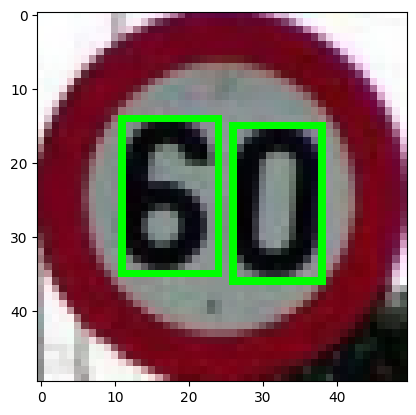

In [8]:

digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]

for contour in digitCnts:
    x, y, w, h = contourRect = cv2.boundingRect(contour)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0))
    print(x, y, w, h, sep="\t")
    r = 28 / max(h, w)
    interp = cv2.INTER_AREA if r < 1 else cv2.INTER_LINEAR
    roi = blur[y:y+h,x:x+w]
    roi = cv2.resize(roi, (int(w*r), int(h*r)), interpolation=interp)
    roismall = letterbox(roi, resize_size)
    roismall = 255 - roismall
    roismall = roismall.reshape((1, 784))
    roismall = np.float32(roismall)
    # retval, results, neigh_resp, dists = knn.findNearest(roismall, k = 2)
    # string += str(int((results[0][0])))
    threshold = np.median(roismall[roismall != 0])
    background_mask = roismall > threshold
    digit_mask = roismall <= threshold
    roismall[background_mask] = 255
    roismall[digit_mask] = 0
    roismall = np.float32(roismall.reshape(1, 28, 28)/255)
    test.append(torch.from_numpy(roismall))
# for contour in digitCnts:
#     if cv2.contourArea(contour) > 85 and cv2.contourArea(contour) < 450:
#         x, y, w, h = contourRect = cv2.boundingRect(contour)
#         if h / w > 1.2 and h/w < 2.5:
#             countContours += 1
#             digitCnts.append(contour)
#             cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0))
#             print(x, y, w, h, sep="\t")
#             r = resize_size[1] / max(h, w)
#             interp = cv2.INTER_AREA if r < 1 else cv2.INTER_LINEAR
#             roi = grayImg[y:y+h,x:x+w]
#             roi = cv2.resize(roi, (int(w*r), int(h*r)), interpolation=interp)
#             roismall = letterbox(roi, resize_size)
#             roismall = roismall.reshape((1, 784))
#             roismall = np.float32(roismall)
#             retval, results, neigh_resp, dists = knn.findNearest(roismall, k = 2)
#             string += str(int((results[0][0])))

#             roismall = np.float32(roismall.reshape(28, 28, 1)/255)
#             background_mask = roismall > 0.1
#             digit_mask = roismall <= 0.1
#             roismall[background_mask] = 1
#             roismall[digit_mask] = 0
#             test.append(roismall)
plt.imshow(img)
plt.show()
print(string)

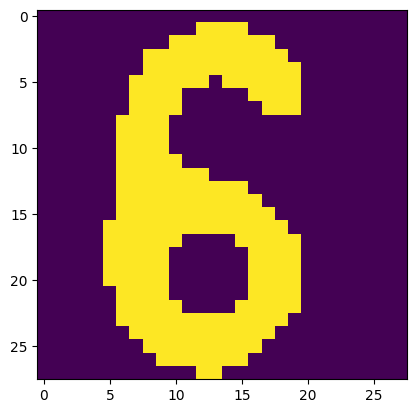

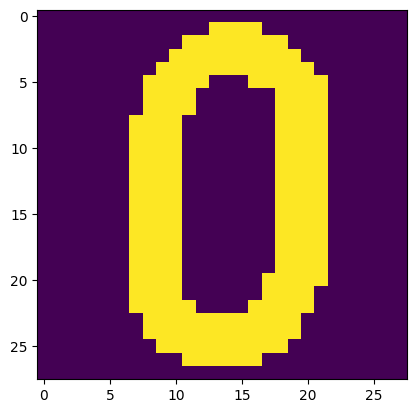

In [457]:
plt.imshow(test[0].reshape(28,28,1))
plt.show()
plt.imshow(test[1].reshape(28,28,1))
plt.show()

In [458]:
model = torch.load("number_recognition_best.pt")
num = torch.stack(test)
preds=model(num)
out = ''
preds = preds.softmax(dim=1).max(dim=1)[1]
for digit in preds:
    out += str(digit.item())
out

'60'

# TRAINING MODEL

In [93]:
# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

# to calculate accuracy
from sklearn.metrics import accuracy_score

# loading the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# n_train = int(0.9*len(samples))
# (X_train, y_train), (X_test, y_test) = (samples[:n_train], responses[:n_train]), (samples[n_train:], responses[n_train:])

In [94]:
# building the input vector from the 28x28 pixels
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255
X_train[X_train > 0.5] = 1
X_train[X_train <= 0.5] = 0
X_test[X_test > 0.5] = 1
X_test[X_test <= 0.5] = 0
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [95]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torchsummary import summary

In [96]:
class MNIST_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

In [97]:
class DigitNet(nn.Module):
    def __init__(self):
        super(DigitNet, self).__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.ReLU()
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        )

        self.dense = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

        # self.net = nn.ModuleList([])
        # self.net.append(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1))
        # self.net.append(nn.BatchNorm2d(num_features=16))
        # self.net.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        # self.net.append(nn.ReLU())
        # self.net.append(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0))
        # self.net.append(nn.BatchNorm2d(num_features=16))
        # self.net.append(nn.ReLU())
        # self.net.append(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1))
        # self.net.append(nn.BatchNorm2d(num_features=32))
        # self.net.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        # self.net.append(nn.ReLU())
        # self.net.append(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0))
        # self.net.append(nn.BatchNorm2d(num_features=64))
        # self.net.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        # self.net.append(nn.ReLU())
        # self.net.append(nn.Flatten())
        # self.net.append(nn.Linear(in_features=576, out_features=800))
        # self.net.append(nn.ReLU())
        # self.net.append(nn.Linear(in_features=800, out_features=256))
        # self.net.append(nn.ReLU())
        # self.net.append(nn.Linear(in_features=256, out_features=64))
        # self.net.append(nn.ReLU())
        # self.net.append(nn.Linear(in_features=64, out_features=10))
        # self.net.append(nn.Softmax(dim=1))
        # self.model = nn.Sequential(*self.net)
    def forward(self, x):
        # out = self.model(x)
        x = self.conv0(x)
        x = self.conv1(x) + self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x) + self.conv5(x)
        x = self.dense(x)
        return x

In [98]:

class InfiniteDataLoader(torch.utils.data.dataloader.DataLoader):
    """ Dataloader that reuses workers

    Uses same syntax as vanilla DataLoader
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        object.__setattr__(self, 'batch_sampler', _RepeatSampler(self.batch_sampler))
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)


class _RepeatSampler(object):
    """ Sampler that repeats forever

    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)



In [99]:
train_data = torch.from_numpy(X_train)
train_label = torch.from_numpy(Y_train)
train_dataset = MNIST_Dataset(train_data, train_label)
dataloader_train = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size=4096, shuffle=True, pin_memory=True)

test_data = torch.from_numpy(X_test)
test_labels = torch.from_numpy(Y_test)
test_dataset = MNIST_Dataset(test_data, test_labels)
dataloader_test = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size=8192, shuffle=True, pin_memory=True)

In [100]:
# Building model
model = DigitNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=1e-4)

In [101]:
summary(model, (1, 28, 28), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 16, 28, 28]             160
       BatchNorm2d-2            [1, 16, 28, 28]              32
         MaxPool2d-3            [1, 16, 14, 14]               0
              ReLU-4            [1, 16, 14, 14]               0
            Conv2d-5            [1, 32, 14, 14]             544
       BatchNorm2d-6            [1, 32, 14, 14]              64
              ReLU-7            [1, 32, 14, 14]               0
            Conv2d-8            [1, 64, 14, 14]          18,496
            Conv2d-9            [1, 16, 14, 14]           1,040
      BatchNorm2d-10            [1, 16, 14, 14]              32
             ReLU-11            [1, 16, 14, 14]               0
           Conv2d-12            [1, 16, 14, 14]             272
      BatchNorm2d-13            [1, 16, 14, 14]              32
             ReLU-14            [1, 16,

In [139]:
# Training model
EPOCHS = 50
best_acc = 0.989
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}/{EPOCHS}: ", end = ' ')
    mean_loss = torch.zeros(1)
    pbar = enumerate(dataloader_train)
    pbar = tqdm(pbar, total=len(dataloader_train))
    model.train()
    for i, data in pbar:
        inputs, targets = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets.max(dim=1)[1])
        loss.backward()
        optimizer.step()
        mean_loss = (mean_loss * i + loss) / (i + 1)
        acc = (outputs.softmax(dim=1).argmax(dim=1) == targets.argmax(dim=1)).sum()
        pbar.set_description("Loss : %.4f, Accuracy: %.4f" % (mean_loss.item(), acc/len(targets)))
    model.eval()
    pbar = enumerate(dataloader_test)
    pbar = tqdm(pbar, total=len(dataloader_test))
    acc = 0.0
    for i, (inputs, targets) in pbar:
        preds = model(inputs)
        acc += (preds.softmax(dim=1).argmax(dim=1) == targets.argmax(dim=1)).sum()
    acc /= len(test_dataset)
    if (acc > best_acc):
        best_acc = acc
        torch.save(model, "number_recognition_best.pt")
    torch.save(model, "number_recognition_last.pt")
    print("Val Accuracy: %.4f" % (acc))

Epoch 0/50:  

100%|██████████| 2/2 [00:24<00:00, 12.06s/it]


Val Accuracy: 0.9891
Epoch 1/50:  

100%|██████████| 2/2 [00:05<00:00,  2.84s/it]


Val Accuracy: 0.9893
Epoch 2/50:  

100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


Val Accuracy: 0.9896
Epoch 3/50:  

100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


Val Accuracy: 0.9893
Epoch 4/50:  

100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Val Accuracy: 0.9894
Epoch 5/50:  

100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


Val Accuracy: 0.9898
Epoch 6/50:  

100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


Val Accuracy: 0.9896
Epoch 7/50:  

100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


Val Accuracy: 0.9893
Epoch 8/50:  

100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


Val Accuracy: 0.9896
Epoch 9/50:  

100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


Val Accuracy: 0.9895
Epoch 10/50:  

100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Val Accuracy: 0.9893
Epoch 11/50:  

100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


Val Accuracy: 0.9894
Epoch 12/50:  

100%|██████████| 2/2 [00:09<00:00,  4.54s/it]


Val Accuracy: 0.9892
Epoch 13/50:  

100%|██████████| 2/2 [00:06<00:00,  3.26s/it]


Val Accuracy: 0.9893
Epoch 14/50:  

100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Val Accuracy: 0.9897
Epoch 15/50:  

100%|██████████| 2/2 [00:13<00:00,  6.88s/it]


Val Accuracy: 0.9895
Epoch 16/50:  

100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


Val Accuracy: 0.9896
Epoch 17/50:  

100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Val Accuracy: 0.9895
Epoch 18/50:  

100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


Val Accuracy: 0.9895
Epoch 19/50:  

100%|██████████| 2/2 [00:09<00:00,  4.96s/it]


Val Accuracy: 0.9895
Epoch 20/50:  

100%|██████████| 2/2 [00:06<00:00,  3.26s/it]


Val Accuracy: 0.9894
Epoch 21/50:  

100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Val Accuracy: 0.9895
Epoch 22/50:  

100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


Val Accuracy: 0.9895
Epoch 23/50:  

100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


Val Accuracy: 0.9896
Epoch 24/50:  

100%|██████████| 2/2 [00:05<00:00,  2.59s/it]


Val Accuracy: 0.9894
Epoch 25/50:  

100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Val Accuracy: 0.9894
Epoch 26/50:  

100%|██████████| 2/2 [00:06<00:00,  3.11s/it]


Val Accuracy: 0.9896
Epoch 27/50:  

100%|██████████| 2/2 [00:06<00:00,  3.03s/it]


Val Accuracy: 0.9895
Epoch 28/50:  

100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


Val Accuracy: 0.9894
Epoch 29/50:  

100%|██████████| 2/2 [00:05<00:00,  2.75s/it]


Val Accuracy: 0.9894
Epoch 30/50:  

100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


Val Accuracy: 0.9895
Epoch 31/50:  

100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


Val Accuracy: 0.9894
Epoch 32/50:  

100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


Val Accuracy: 0.9892
Epoch 33/50:  

100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


Val Accuracy: 0.9894
Epoch 34/50:  

100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


Val Accuracy: 0.9894
Epoch 35/50:  

100%|██████████| 2/2 [00:05<00:00,  2.88s/it]


Val Accuracy: 0.9896
Epoch 36/50:  

100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


Val Accuracy: 0.9891
Epoch 37/50:  

100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


Val Accuracy: 0.9894
Epoch 38/50:  

100%|██████████| 2/2 [00:06<00:00,  3.35s/it]


Val Accuracy: 0.9893
Epoch 39/50:  

100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Val Accuracy: 0.9892
Epoch 40/50:  

100%|██████████| 2/2 [00:05<00:00,  2.75s/it]


Val Accuracy: 0.9894
Epoch 41/50:  

100%|██████████| 2/2 [00:04<00:00,  2.45s/it]


Val Accuracy: 0.9893
Epoch 42/50:  

100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Val Accuracy: 0.9891
Epoch 43/50:  

100%|██████████| 2/2 [00:04<00:00,  2.50s/it]


Val Accuracy: 0.9892
Epoch 44/50:  

100%|██████████| 2/2 [00:06<00:00,  3.03s/it]


Val Accuracy: 0.9894
Epoch 45/50:  

100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Val Accuracy: 0.9892
Epoch 46/50:  

100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


Val Accuracy: 0.9892
Epoch 47/50:  

100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Val Accuracy: 0.9891
Epoch 48/50:  

100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


Val Accuracy: 0.9891
Epoch 49/50:  

100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


Val Accuracy: 0.9893


In [96]:
torch.save(model, "number_recognition.pt")

In [224]:
# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(10, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(14,14,10)))
model.add(MaxPool2D(pool_size=(2,2)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(512, activation='relu'))
# hidden layer
model.add(Dense(128, activation='relu'))
# output layer
model.add(Dense(10, activation='softmax'))
print(model.summary())
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 32)        2912      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1568)              0         
                                                                 
 dense_20 (Dense)            (None, 512)              

In [260]:
# training the model for 10 epochs
model.fit(X_train, Y_train, batch_size=4096, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
15/15 [==============================] - 11s 729ms/step - loss: 5.8006e-04 - accuracy: 1.0000 - val_loss: 0.1011 - val_accuracy: 0.9783
Epoch 2/10
15/15 [==============================] - 12s 834ms/step - loss: 5.8577e-04 - accuracy: 1.0000 - val_loss: 0.1074 - val_accuracy: 0.9767
Epoch 3/10
15/15 [==============================] - 13s 878ms/step - loss: 5.1138e-04 - accuracy: 1.0000 - val_loss: 0.1010 - val_accuracy: 0.9782
Epoch 4/10
15/15 [==============================] - 12s 835ms/step - loss: 5.0952e-04 - accuracy: 1.0000 - val_loss: 0.0954 - val_accuracy: 0.9798
Epoch 5/10
15/15 [==============================] - 13s 836ms/step - loss: 4.7740e-04 - accuracy: 1.0000 - val_loss: 0.1082 - val_accuracy: 0.9763
Epoch 6/10
15/15 [==============================] - 13s 841ms/step - loss: 4.6041e-04 - accuracy: 1.0000 - val_loss: 0.1040 - val_accuracy: 0.9780
Epoch 7/10
15/15 [==============================] - 13s 849ms/step - loss: 4.5068e-04 - accuracy: 1.0000 - val_loss: 0

In [259]:
model.save("number_classification")

INFO:tensorflow:Assets written to: number_classification\assets


INFO:tensorflow:Assets written to: number_classification\assets


In [104]:
classifier = keras.models.load_model("number_classification")

In [128]:
np.asarray(test).shape

(2, 28, 28, 1)

In [364]:
pred = model.predict(np.asarray(test))

1/1 [==============================] - 0s 27ms/step


In [365]:
pred.argmax(axis=1)

array([6, 0], dtype=int64)

In [74]:
a = X_train[0]
a[a > 0.3] = 1
a[a != 1] = 0

In [115]:
torch.from_numpy(X_train[0]).permute(1,2,0)[10]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

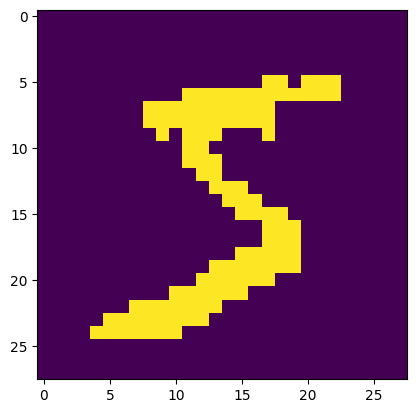

In [116]:
plt.imshow(torch.from_numpy(X_train[0]).permute(1,2,0))

In [141]:
Y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [411]:
num = torch.stack([torch.from_numpy(test[0]), torch.from_numpy(test[1])])

In [302]:
num.shape

torch.Size([2, 1, 28, 28])

In [260]:
model_best = torch.load("number_recognition_best.pt")

In [412]:
preds_0 = model(num)
preds_1 = model_best(num)

In [413]:
preds_0.softmax(dim=1), preds_1.softmax(dim=1)

(tensor([[2.4687e-03, 6.5712e-04, 1.5080e-05, 1.2199e-05, 4.0041e-04, 8.6358e-02,
          9.0488e-01, 1.9906e-04, 5.0030e-03, 3.7380e-06],
         [9.9769e-01, 2.2288e-04, 2.4554e-04, 7.5558e-05, 7.7854e-04, 4.2912e-04,
          1.9092e-04, 1.4514e-05, 1.2307e-04, 2.3168e-04]],
        grad_fn=<SoftmaxBackward>),
 tensor([[3.9095e-03, 1.1210e-03, 2.9479e-05, 2.4245e-05, 6.2291e-04, 1.0825e-01,
          8.7858e-01, 3.0645e-04, 7.1456e-03, 8.8975e-06],
         [9.9617e-01, 3.9672e-04, 4.1224e-04, 1.2547e-04, 1.2278e-03, 7.2240e-04,
          3.2492e-04, 2.8271e-05, 2.1865e-04, 3.7621e-04]],
        grad_fn=<SoftmaxBackward>))

In [414]:
preds_0.softmax(dim=1).max(dim=1), preds_1.softmax(dim=1).max(dim=1)

(torch.return_types.max(
 values=tensor([0.9049, 0.9977], grad_fn=<MaxBackward0>),
 indices=tensor([6, 0])),
 torch.return_types.max(
 values=tensor([0.8786, 0.9962], grad_fn=<MaxBackward0>),
 indices=tensor([6, 0])))

In [247]:
test[0][test[0] != 1] = 0

In [131]:
test[1][test[1] < 0.2] = 0
test[1][test[1] >= 0.2] = 1